## Driver code comparing output of different atlas / parcellations 

### Steps
- import data csvs from different atlases
- compare performance of machine-learning model (scikit-learn)
- compare performance of statsmodels (ols or logit)

In [1]:
import sys
import numpy as np
import pandas as pd
import itertools

from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import time

sys.path.append('../')
from lib.data_handling import *
from lib.data_stats import *

### Data paths

In [2]:
proj_dir = '/home/nikhil/projects/CT_reproduce/code/compare-surf-tools/'
data_dir = proj_dir + 'data/'
results_dir = data_dir + 'results/'
qc_dir =  '/home/nikhil/projects/CT_reproduce/data/QC/'
fs60_dir = data_dir + 'fs60_group_stats/'
demograph_file = 'ABIDE_Phenotype.csv'

#fs60 all files
# Thickness
fs60_aparc_lh_thickness_file = 'lh.aparc.thickness.table.test1'
fs60_aparc_rh_thickness_file = 'rh.aparc.thickness.table.test1' #34 ROIs
fs60_aparc2009_lh_thickness_file = 'lh.aparc.a2009.thickness.table.test1' #74 ROIs per hemi
fs60_aparc2009_rh_thickness_file = 'rh.aparc.a2009.thickness.table.test1'
fs60_glasser_lh_thickness_file = 'lh.glasser.thickness.table.test1' #180 ROIs per hemi
fs60_glasser_rh_thickness_file = 'rh.glasser.thickness.table.test1'


# Surface Area
# fs60_aparc_lh_SA_file = 'aparc_lh_SA_table.test1'
# fs60_aparc_rh_SA_file = 'aparc_rh_SA_table.test1'
# fs60_aparc2009_lh_SA_file = 'lh.aparc.a2009.SA.table.test1'
# fs60_aparc2009_rh_SA_file = 'rh.aparc.a2009.SA.table.test1'


### Global Vars

In [3]:
subject_ID_col = 'SubjID'

### Load data

In [4]:
# Demographics and Dx
demograph = pd.read_csv(data_dir + demograph_file)
demograph = demograph.rename(columns={'Subject_ID':subject_ID_col})

# aparc
aparc = 'aparc'
fs60_aparc_lh_thickness_data = pd.read_csv(fs60_dir + fs60_aparc_lh_thickness_file, delim_whitespace=True)
fs60_aparc_rh_thickness_data = pd.read_csv(fs60_dir + fs60_aparc_rh_thickness_file, delim_whitespace=True)
print('shape of fs60 aparc data l: {}, r: {}'.format(fs60_aparc_lh_thickness_data.shape,fs60_aparc_rh_thickness_data.shape))
fs60_aparc_thickness_data_std = standardize_fs60_data(fs60_aparc_lh_thickness_data, 
                                                      fs60_aparc_rh_thickness_data, subject_ID_col, aparc)
print('shape of stdized fs60 aparc data {}'.format(fs60_aparc_thickness_data_std.shape))


# Destrieux
aparc = 'aparc.a2009s'
fs60_aparc2009_lh_thickness_data = pd.read_csv(fs60_dir + fs60_aparc2009_lh_thickness_file, delim_whitespace=True)
fs60_aparc2009_rh_thickness_data = pd.read_csv(fs60_dir + fs60_aparc2009_rh_thickness_file, delim_whitespace=True)
print('shape of fs60 aparc2009 data l: {}, r: {}'.format(fs60_aparc2009_lh_thickness_data.shape,fs60_aparc2009_rh_thickness_data.shape))
fs60_aparc2009_thickness_data_std = standardize_fs60_data(fs60_aparc2009_lh_thickness_data,
                                                          fs60_aparc2009_rh_thickness_data, subject_ID_col, aparc)
print('shape of stdized fs60 aparc data {}'.format(fs60_aparc2009_thickness_data_std.shape))


# Glasser
aparc = 'aparc.Glasseratlas'
fs60_glasser_lh_thickness_data = pd.read_csv(fs60_dir + fs60_glasser_lh_thickness_file, delim_whitespace=True)
fs60_glasser_rh_thickness_data = pd.read_csv(fs60_dir + fs60_glasser_rh_thickness_file, delim_whitespace=True)
print('shape of fs60 glasser data l: {}, r: {}'.format(fs60_glasser_lh_thickness_data.shape,fs60_glasser_rh_thickness_data.shape))
fs60_glasser_thickness_data_std = standardize_fs60_data(fs60_glasser_lh_thickness_data,
                                                          fs60_glasser_rh_thickness_data, subject_ID_col, aparc)
print('shape of stdized fs60 aparc data {}'.format(fs60_glasser_thickness_data_std.shape))


shape of fs60 aparc data l: (1047, 36), r: (1047, 36)
shape of left and right merge fs6.0 df (1047, 71)
shape of stdized fs60 aparc data (1047, 71)
shape of fs60 aparc2009 data l: (1047, 76), r: (1047, 76)
shape of left and right merge fs6.0 df (1047, 151)
shape of stdized fs60 aparc data (1047, 151)
shape of fs60 glasser data l: (1047, 182), r: (1047, 182)
shape of left and right merge fs6.0 df (1047, 363)
shape of stdized fs60 aparc data (1047, 363)


### Create master dataframe

In [5]:
data_dict = {'aparc' : fs60_aparc_thickness_data_std,
            'Destrieux' : fs60_aparc2009_thickness_data_std,
            'Glasser' : fs60_glasser_thickness_data_std}

# Add demographic columns to the master_df
useful_demograph = demograph[[subject_ID_col,'SEX','AGE_AT_SCAN','DX_GROUP','SITE_ID']].copy()

# Shift to (0 and 1 instead of 1 and 2 for statsmodels)
# DX_GROUP: (orginal: 1:ASD, 2:Controls, after shift 0:ASD, 1:Controls)
useful_demograph['DX_GROUP'] = useful_demograph['DX_GROUP']-1
useful_demograph['SEX'] = useful_demograph['SEX']-1

_,useful_demograph[subject_ID_col] = useful_demograph[subject_ID_col].str.rsplit('_', 1).str

### Compare ML performance 

In [17]:
qc_type = 'maarten' #condition: master_df['QC_maarten']==0, master_df['QC_gleb'].isin['1','-+1']
    
model_type = 'regression'

if model_type.lower() == 'regression':
    outcome_col = 'AGE_AT_SCAN'
    covar_continuous_cols = []
    covar_cat_cols = ['SEX','SITE_ID','DX_GROUP']

    model = RandomForestRegressor(max_depth=2, random_state=0, n_estimators=100)
else: 
    outcome_col = 'DX_GROUP'
    covar_continuous_cols = ['AGE_AT_SCAN']
    covar_cat_cols = ['SEX','SITE_ID']
    
    #model = svm.SVC(kernel='linear')
    model = RandomForestClassifier(n_estimators=50, max_depth=2,random_state=0)

ml_perf_concat = pd.DataFrame()

start_time_ML = time.time()
for atlas in data_dict.keys():
    start_time_atlas = time.time()
    print('Atlas {}'.format(atlas))
    master_df_raw = pd.merge(useful_demograph,data_dict[atlas],on= subject_ID_col)

    if qc_type in ['maarten','gleb']:
        qc_df = pd.read_csv(qc_dir + 'master_QC_table.csv',dtype={'SubjID': str})
        master_df = pd.merge(master_df_raw, qc_df, how='left', on=subject_ID_col)
        master_df = master_df[master_df['QC_maarten']==0]
        print('Filtering based on {} QC. Resultant number of subjects {} ({})'.format(qc_type,len(master_df[subject_ID_col].unique()),master_df['DX_GROUP'].value_counts().to_dict()))
        common_subs = master_df[subject_ID_col].unique()
    else:
        master_df = master_df_raw
        print('No QC performed. master_df shape {}'.format(len(master_df[subject_ID_col].unique())))
    
    
    roi_cols = master_df.filter(regex='^L|R_', axis=1).columns
    #master_df['pipeline'] = np.tile(atlas,len(master_df))
    ml_perf = getMLModelPerf(master_df,roi_cols, covar_continuous_cols,covar_cat_cols,outcome_col,model_type,model)
    ml_perf['atlas'] = np.tile(atlas,len(ml_perf))
    ml_perf_concat = ml_perf_concat.append(ml_perf)
    
    print('time to process atlas {:4.3f}s \n'.format(time.time()-start_time_atlas))
    

print('time to process ML {:4.3}s'.format(time.time()-start_time_ML))


Atlas Destrieux
Filtering based on maarten QC. Resultant number of subjects 975 ({0: 450, 1: 525})
Using 3 col for 22 cat covar
Data shapes X (975, 170), y 975 (17.24m, 8.02sd)
Using regression model with perf metric neg_mean_squared_error
 Perf mean:-34.917, sd:7.932
time to process atlas 99.509s 

Atlas aparc
Filtering based on maarten QC. Resultant number of subjects 975 ({0: 450, 1: 525})
Using 3 col for 22 cat covar
Data shapes X (975, 90), y 975 (17.24m, 8.02sd)
Using regression model with perf metric neg_mean_squared_error
 Perf mean:-34.770, sd:7.818
time to process atlas 49.113s 

Atlas Glasser
Filtering based on maarten QC. Resultant number of subjects 975 ({0: 450, 1: 525})
Using 3 col for 22 cat covar
Data shapes X (975, 382), y 975 (17.24m, 8.02sd)
Using regression model with perf metric neg_mean_squared_error
 Perf mean:-35.969, sd:8.057
time to process atlas 260.492s 

time to process ML 4.09e+02s


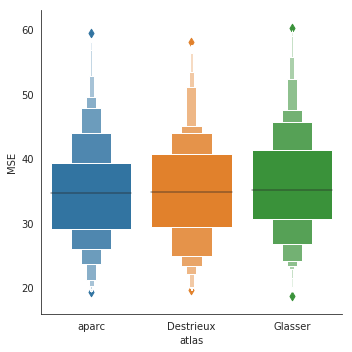

In [18]:
ml_perf_concat['MSE'] = -1*ml_perf_concat['neg_mean_squared_error']
x_order = ['aparc','Destrieux','Glasser']
with sns.axes_style("white"): 
    g = sns.catplot(y='MSE',x='atlas',kind='boxen',data=ml_perf_concat, order=x_order)
    #g.set(ylim=(0, 80))


### Compare statsmodels performance 

In [13]:
covar_continuous_cols = ['AGE_AT_SCAN']
covar_cat_cols = ['SEX','SITE_ID']
outcome_col = 'DX_GROUP' #AGE_AT_SCAN #DX_GROUP #SEX
stat_model = 'logit' #ols #logit
stat_perf_dict = {}
save_sm_perf = False
qc_type = 'maarten'

for atlas in data_dict.keys():
    mr_data_df = data_dict[atlas]
    roi_cols = list(mr_data_df.filter(regex='^L|R_', axis=1).columns)
    master_df_raw = pd.merge(useful_demograph,mr_data_df[[subject_ID_col]+ roi_cols],on=subject_ID_col)
    
    if qc_type in ['maarten','gleb']:
        qc_df = pd.read_csv(qc_dir + 'master_QC_table.csv',dtype={'SubjID': str})
        master_df = pd.merge(master_df_raw, qc_df, how='left', on=subject_ID_col)
        master_df = master_df[master_df['QC_maarten']==0]
        print('Filtering based on {} QC. Resultant number of subjects {} ({})'.format(qc_type,len(master_df[subject_ID_col].unique()),master_df['DX_GROUP'].value_counts().to_dict()))
        common_subs = master_df[subject_ID_col].unique()
    else:
        master_df = master_df_raw
        print('No QC performed. master_df shape {}'.format(len(master_df[subject_ID_col].unique())))
    
    master_df['atlas'] = np.tile(atlas,len(master_df))
    
    #Save standarized df to csv for outlier detection
    #master_df.to_csv(fs60_dir + '{}_standarized.csv'.format(atlas))
    
    sm_perf = getStatModelPerf(master_df,roi_cols,covar_continuous_cols,covar_cat_cols,outcome_col,stat_model)
    stat_perf_dict[atlas] = sm_perf
    print('Shape of the stats_models results df {}'.format(sm_perf.shape))
    print('Top 10 significant regions:\n {}'.format(sm_perf.sort_values(by=['p_val']).head(10)))
    print('')
    
if save_sm_perf:
    save_path = '{}atlas_sm_perf_{}_QC_{}_N_{}.pkl'.format(results_dir,outcome_col,qc_type,len(common_subs))
    print('Saving sm_perf dictionary at \n{}'.format(save_path))
    with open(save_path, 'wb') as handle:
        pickle.dump(stat_perf_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)


Filtering based on maarten QC. Resultant number of subjects 975 ({0: 450, 1: 525})
Example statsmodel run:
 DX_GROUP ~ R_p24_ROI + AGE_AT_SCAN + C(SEX) + C(SITE_ID)
Shape of the stats_models results df (360, 3)
Top 10 significant regions:
             roi     t_val     p_val
183    R_V2_ROI -4.067980  0.000047
0      L_V1_ROI -3.879805  0.000105
3      L_V2_ROI -3.598016  0.000321
341   R_31a_ROI -3.485909  0.000490
169  L_p10p_ROI -3.247705  0.001163
339  R_VMV2_ROI -3.067708  0.002157
174    L_A4_ROI -3.028458  0.002458
285  R_PoI2_ROI  3.009775  0.002614
124    L_A5_ROI -2.758232  0.005811
349  R_p10p_ROI -2.621618  0.008751

Filtering based on maarten QC. Resultant number of subjects 975 ({0: 450, 1: 525})
Example statsmodel run:
 DX_GROUP ~ R_insula + AGE_AT_SCAN + C(SEX) + C(SITE_ID)
Shape of the stats_models results df (68, 3)
Top 10 significant regions:
                       roi     t_val     p_val
45              R_lingual -3.240694  0.001192
19        L_pericalcarine -2.9135

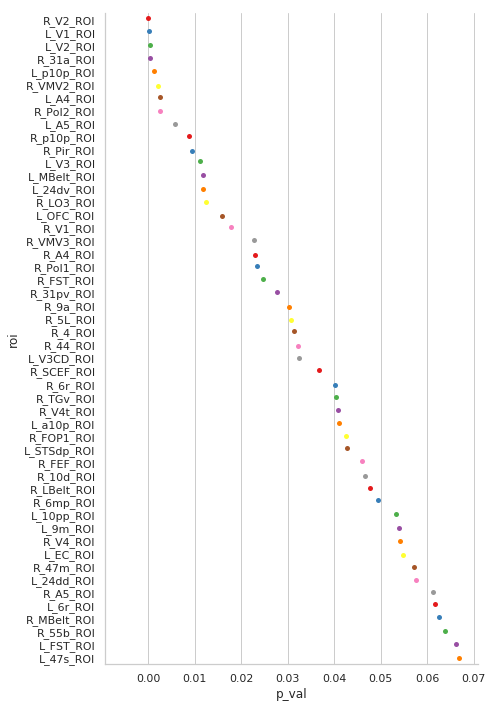

In [17]:
# Plots
aparc = 'Glasser' #'Destrieux', 'aparc','Glasser'
top_rois = 50
plot_df = stat_perf_dict[aparc].sort_values(by=['p_val']).head(top_rois)

sns.set(font_scale=1)
with sns.axes_style("whitegrid"):
    g = sns.catplot(x='p_val',y='roi',kind='strip',
                    data=plot_df,palette='Set1',height=10,aspect=0.7)
    #g.set(xscale="log");